# Top-level tests

In [1]:
%reset -f
%matplotlib inline
from copy import copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

from disp import set_font_size
from seq_replay.plot import heat_maps, raster
from seq_replay.cxn import apx_lattice
from seq_replay.smln import fix_schedule, build_ntwk, build_trj
from seq_replay.smln import get_trj_veil, apx_ws_up, build_stim
from seq_replay.smln import get_metrics

## Test approximate lattice construction

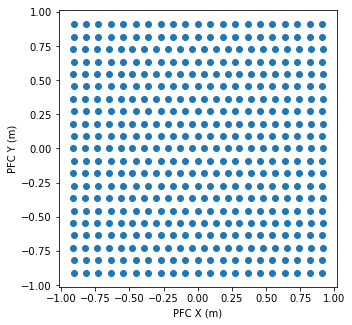

In [2]:
lb = [-1, -1]
ub = [1, 1]
n = 450

xs, ys = apx_lattice(lb, ub, n, randomize=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
ax.set_aspect('equal')

ax.scatter(xs, ys)

ax.set_xlabel('PFC X (m)')
ax.set_ylabel('PFC Y (m)');

## Build ntwk

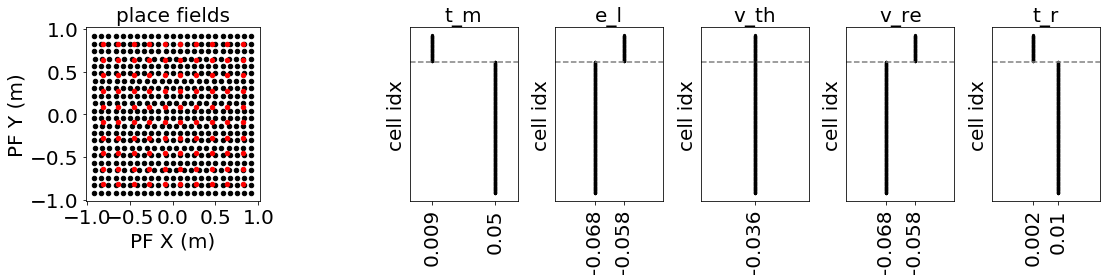

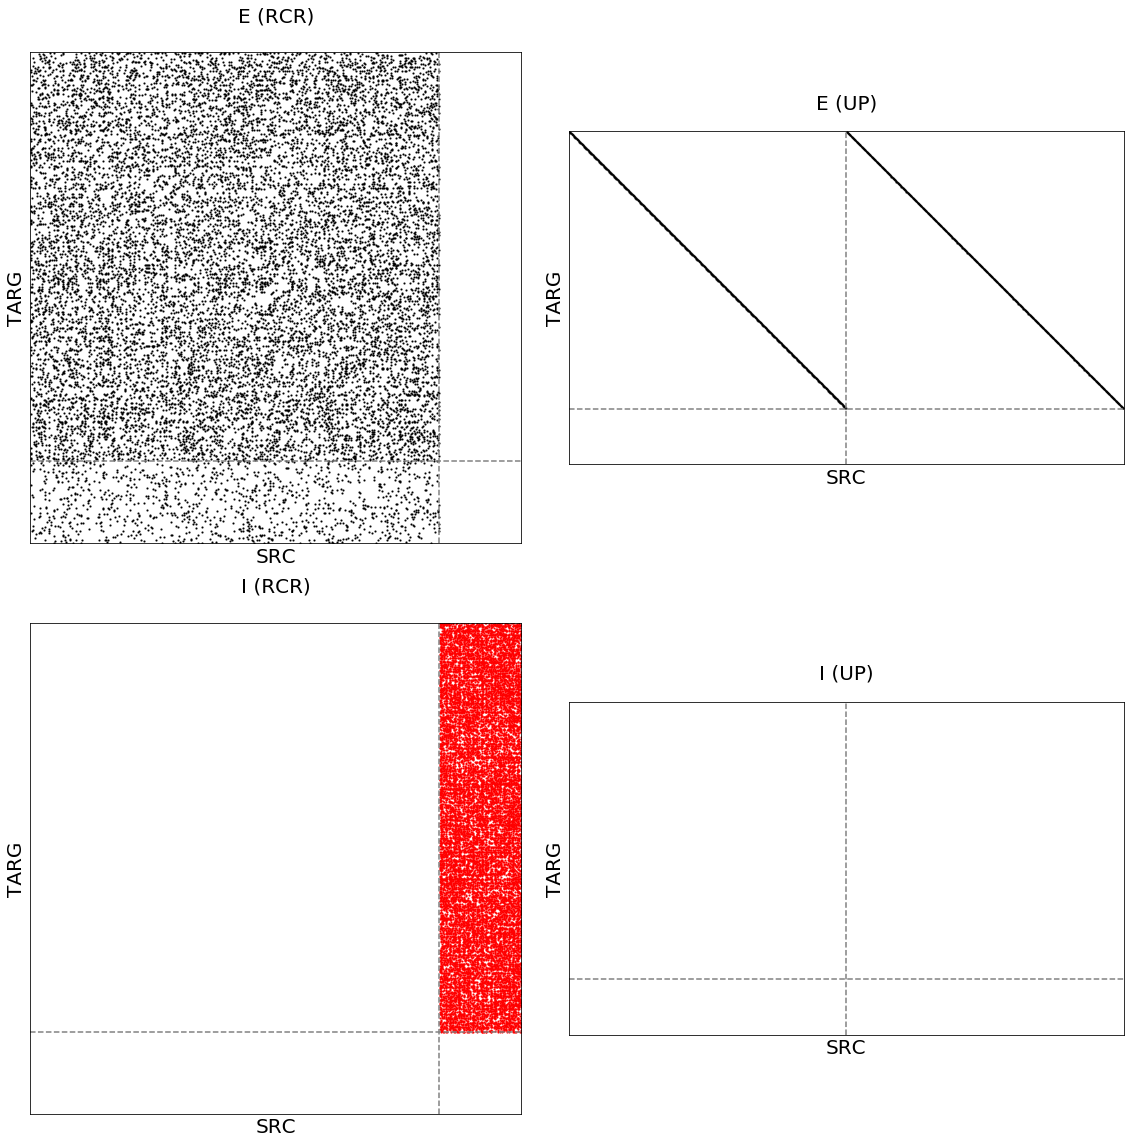

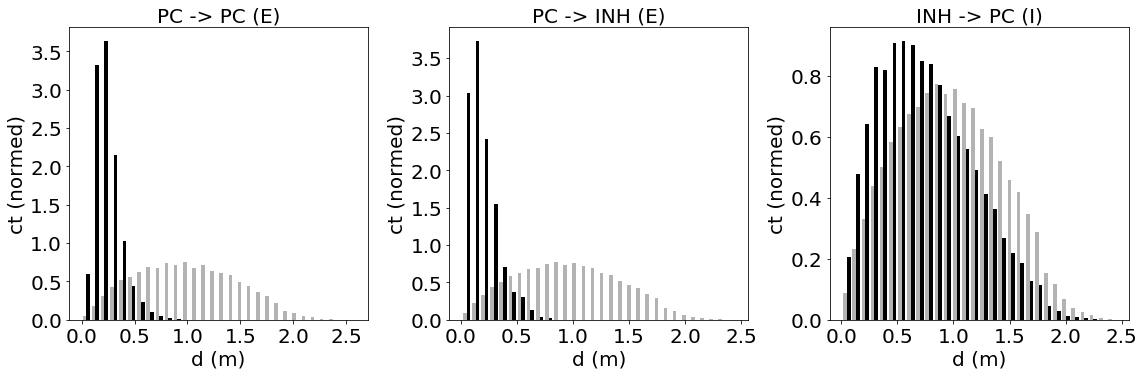

In [3]:
# set params
p = {
    'N_PC': 500,
    'N_INH': 100,
    
    'T_M_PC': 0.05,
    'E_L_PC': -0.068,
    'V_TH_PC': -0.036,
    'V_R_PC': -0.068,
    'T_RP_PC': 0.01, 
    
    'T_M_INH': 0.009,
    'E_L_INH': -0.058,
    'V_TH_INH': -0.036,
    'V_R_INH': -0.058,
    'T_RP_INH': 0.002,
    
    'T_AHP_PC': 0.03,
    'E_AHP_PC': -0.08,
    'W_AHP_PC': 0,
    
    'L_PL': 0.2,
    'R_MAX': 50,
    'S_TH': .1,
    'B_S': .04,
    
    'E_E': 0,
    'E_I': -0.08,
    'T_E': .002,
    'T_I': .005,
    
    'Z_PC_PC': 5,
    'L_PC_PC': 0.1,
    'Z_INH_PC': 1.5,
    'L_INH_PC': 0.1,
    'Z_S_PC_INH': 1,
    'L_S_PC_INH': .8,
    'Z_C_PC_INH': 6,
    'Z_C_PC_INH': 0.3,
    
    'W_E_PC_PC': 0.01,
    'S_E_PC_PC': 0.002,
    
    'W_E_INH_PC': 0.01,
    'S_E_INH_PC': 0.002,
    
    'W_I_PC_INH': 0.02,
    'S_I_PC_INH': 0.004,
    
    'W_E_PC_PL': 0.01,
    'S_E_PC_PL': 0.002,
    
    'W_E_INIT_PC_ST': 0.01,
    'S_E_INIT_PC_ST': 0.002,
    
    'A_P': 2,
    'T_W': 1,
    'T_C': 1.5,
    'C_S': 10,
    'B_C': 0.2,
    
    'FR_TRJ_PC_ST': 5,
    'FR_RPL_PC_ST': 50,
}

s_params = {
    'RNG_SEED': 0,
    'BOX_W': 2,
    'BOX_H': 2,
}

# build ntwk
ntwk = build_ntwk(p, s_params)

# plot PC/INH positions
gs = gridspec.GridSpec(2, 8)
fig = plt.figure(figsize=(16, 4), tight_layout=True)

ax_0 = fig.add_subplot(gs[:, :3])

# PCs
pc_mask = ntwk.types_rcr == 'PC'
ax_0.scatter(ntwk.pfxs[pc_mask], ntwk.pfys[pc_mask], c='k', s=20)

# INHs
inh_mask = ntwk.types_rcr == 'INH'
ax_0.scatter(ntwk.pfxs[inh_mask], ntwk.pfys[inh_mask], c='r', s=20)
ax_0.set_aspect('equal')

ax_0.set_xlabel('PF X (m)')
ax_0.set_ylabel('PF Y (m)')
ax_0.set_title('place fields')

# plot membrane properties
attrs = ['t_m', 'e_l', 'v_th', 'v_reset', 't_r']
axs = [fig.add_subplot(gs[:, ctr]) for ctr in range(3, 8)]

for attr, ax in zip(attrs, axs):
    vals = getattr(ntwk, attr)
    ax.scatter(vals, range(len(vals)), c='k', s=5)
    ax.axhline(p['N_PC'] - 0.5, color='gray', ls='--')
    
    ax.set_xticks(sorted(set(vals)))
    ax.set_xticklabels(sorted(set(vals)), rotation=90)
    ax.set_yticks([])
    
    ax.set_ylabel('cell idx')
    ax.set_title(attr[:4])


for ax in [ax_0] + list(axs):
    set_font_size(ax, 20)

    
# plot weight matrix sparsity patterns
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(16, 16), tight_layout=True)

# E rcr cxns
ax_0 = fig.add_subplot(gs[0, 0])
ax_0.spy(ntwk.ws_rcr['E'], c='k', markersize=1)
ax_0.set_title('E (RCR)')

# E up cxns
ax_1 = fig.add_subplot(gs[0, 1])
ax_1.spy(ntwk.ws_up_init['E'], c='k', markersize=1)
ax_1.set_title('E (UP)')

# I rcr cxns
ax_2 = fig.add_subplot(gs[1, 0])
ax_2.spy(ntwk.ws_rcr['I'], c='r', markersize=1)
ax_2.set_title('I (RCR)')

# I up cxns
ax_3 = fig.add_subplot(gs[1, 1])
ax_3.spy(ntwk.ws_up_init['I'], c='r', markersize=1)
ax_3.set_title('I (UP)')

for ax in [ax_0, ax_1, ax_2, ax_3]:
    ax.axhline(p['N_PC'] - 0.5, color='gray', ls='--')
    ax.axvline(p['N_PC'] - 0.5, color='gray', ls='--')
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('SRC')
    ax.set_ylabel('TARG')
    
    set_font_size(ax, 20)


# plot distributions of distances for cxns vs. non-cxns between diff cell types
dx = np.tile(ntwk.pfxs[None, :], (ntwk.n, 1)) - np.tile(ntwk.pfxs[:, None], (1, ntwk.n))
dy = np.tile(ntwk.pfys[None, :], (ntwk.n, 1)) - np.tile(ntwk.pfys[:, None], (1, ntwk.n))
d = np.sqrt(dx**2 + dy**2)

fig, axs = plt.subplots(1, 3, figsize=(16, 16/3), tight_layout=True)

# PC-PC E cxns
d_pc_pc = d[pc_mask, :][:, pc_mask]
w_e_pc_pc = ntwk.ws_rcr['E'][pc_mask, :][:, pc_mask]
d_pc_pc_cxn = d_pc_pc[(w_e_pc_pc > 0).todense()]

axs[0].hist(
    [d_pc_pc.flatten(), d_pc_pc_cxn.flatten()], color=[(.7, .7, .7), 'k'],
    bins=30, normed=True)
axs[0].set_title('PC -> PC (E)')

# PC->INH E cxns
d_inh_pc = d[inh_mask, :][:, pc_mask]
w_e_inh_pc = ntwk.ws_rcr['E'][inh_mask, :][:, pc_mask]
d_inh_pc_cxn = d_inh_pc[(w_e_inh_pc > 0).todense()]

axs[1].hist(
    [d_inh_pc.flatten(), d_inh_pc_cxn.flatten()],color=[(.7, .7, .7), 'k'],
    bins=30, normed=True)
axs[1].set_title('PC -> INH (E)')

# INH->PC I cxns
d_pc_inh = d[pc_mask, :][:, inh_mask]
w_i_pc_inh = ntwk.ws_rcr['I'][pc_mask, :][:, inh_mask]
d_pc_inh_cxn = d_pc_inh[(w_i_pc_inh > 0).todense()]

axs[2].hist(
    [d_pc_inh.flatten(), d_pc_inh_cxn.flatten()], color=[(.7, .7, .7), 'k'],
    bins=30, normed=True)
axs[2].set_title('INH -> PC (I)')

for ax in axs:
    ax.set_xlabel('d (m)')
    ax.set_ylabel('ct (normed)')
    set_font_size(ax, 20)

## Build a trajectory

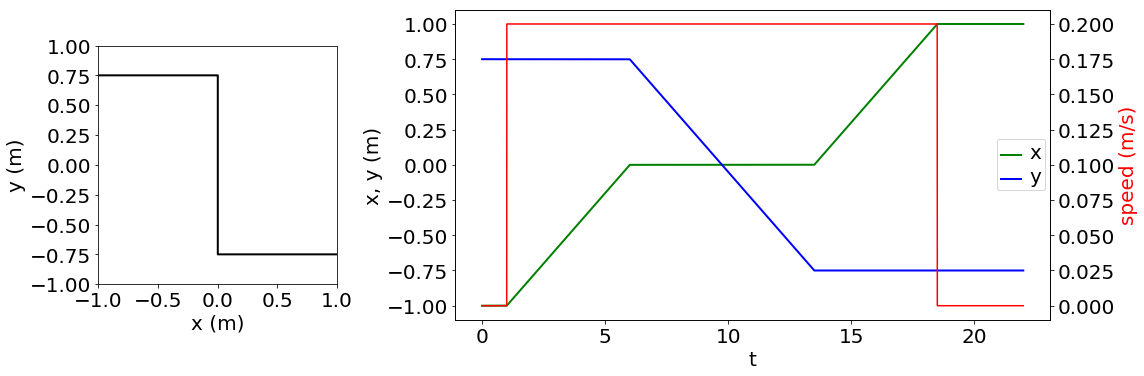

In [4]:
schedule = {
    'SMLN_DUR': 22,
    'TRJ_START_T': 1,
    'REPLAY_EPOCH_START_T': 20,
    'TRG_START_T': 21,
}

s_params['DT'] = 0.0005
s_params['START_X'] = -1
s_params['START_Y'] = .75
s_params['TURN_X'] = 0
s_params['TURN_Y'] = -0.75
s_params['END_X'] = 1
s_params['SPEED'] = .2

t = np.arange(0, schedule['SMLN_DUR'], s_params['DT'])

trj = build_trj(t, s_params, schedule)

# plot trajectory
gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(16, 16/3), tight_layout=True)

ax_0 = fig.add_subplot(gs[0, 0])
ax_0.plot(trj['x'], trj['y'], c='k', lw=2)

ax_0.set_xlim(-s_params['BOX_W']/2, s_params['BOX_W']/2)
ax_0.set_ylim(-s_params['BOX_H']/2, s_params['BOX_H']/2)

ax_0.set_aspect('equal')

ax_0.set_xlabel('x (m)')
ax_0.set_ylabel('y (m)')

ax_1 = fig.add_subplot(gs[0, 1:])
ax_1.plot(t, trj['x'], c='g', lw=2)
ax_1.plot(t, trj['y'], c='b', lw=2)

ax_1.set_xlabel('t')
ax_1.set_ylabel('x, y (m)')
ax_1.legend(['x', 'y'])

ax_2 = ax_1.twinx()
ax_2.plot(t, trj['sp'], 'r')

ax_2.set_ylabel('speed (m/s)', color='r')

for ax in [ax_0, ax_1, ax_2]:
    set_font_size(ax, 20)

## Get trajectory "veil" and ST->PC wt apxn

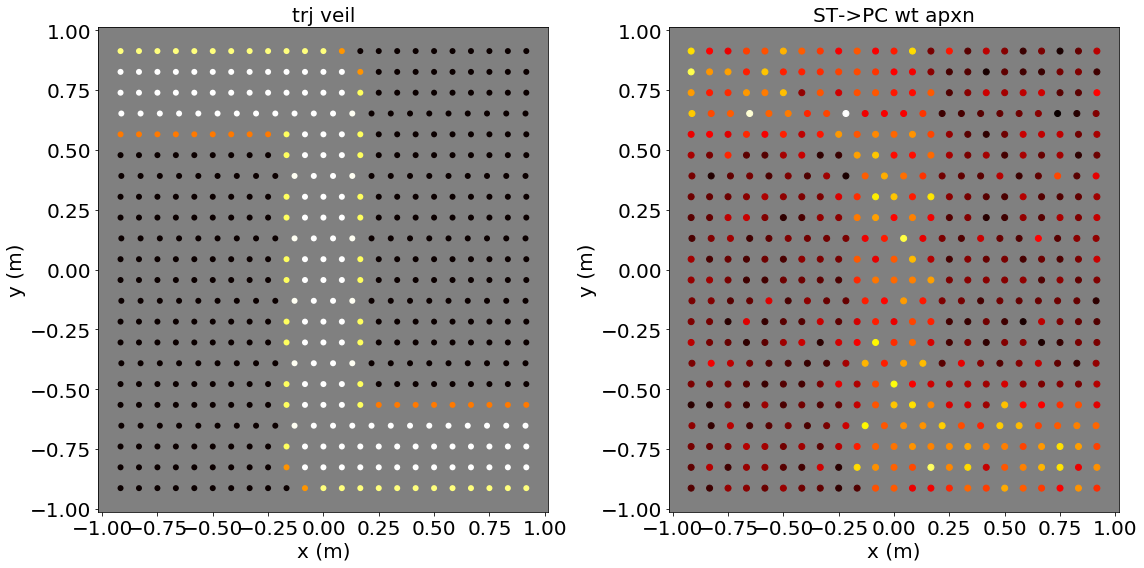

In [5]:
s_params['metrics'] = {
    'RADIUS': 0.2,
    'PITCH': 10,
}

trj_veil = get_trj_veil(trj, ntwk, p, s_params)
ntwk = apx_ws_up(ntwk, trj_veil)

# plot heatmap of trj veil
fig, axs = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)

axs[0].scatter(
    ntwk.pfxs[pc_mask], ntwk.pfys[pc_mask], c=trj_veil[pc_mask], lw=0,
    vmin=trj_veil[pc_mask].min(), vmax=trj_veil[pc_mask].max(), cmap='hot')
axs[0].set_title('trj veil')

# plot heatmap of increased ST->PC cxns
st_mask = ntwk.types_up == 'ST'
c = ntwk.ws_up_init['E'][pc_mask, :][:, st_mask].diagonal()

axs[1].scatter(
    ntwk.pfxs[pc_mask], ntwk.pfys[pc_mask], c=c, vmin=c.min(), vmax=c.max(), cmap='hot')
axs[1].set_title('ST->PC wt apxn')

for ax in axs:
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    
    ax.set_facecolor('gray')
    
    set_font_size(ax, 20)

## Build full stimulus

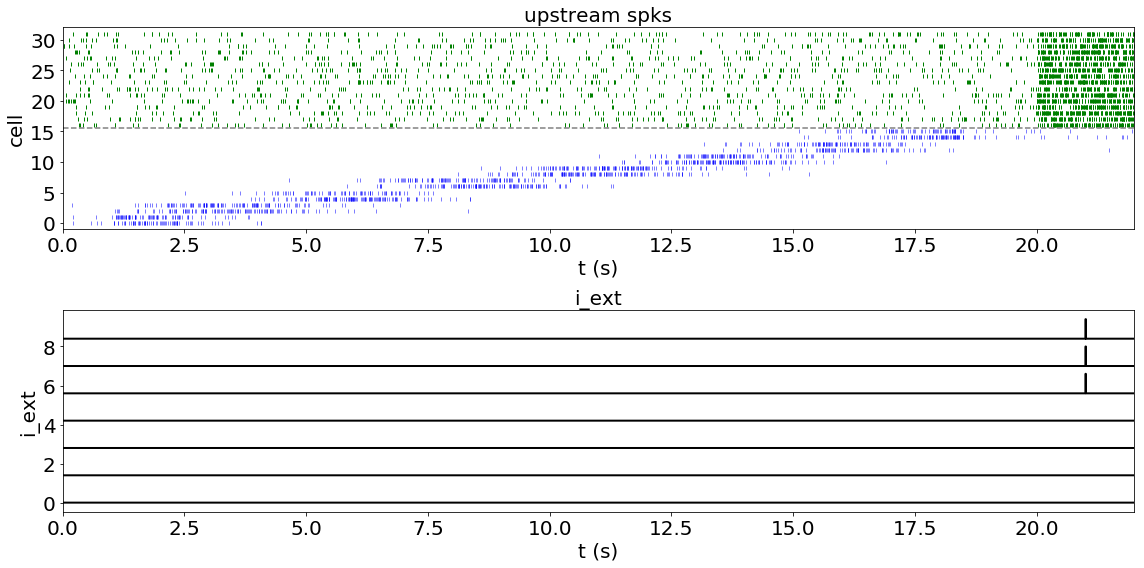

In [6]:
from seq_replay.plot import get_idxs_nearest
from seq_replay.smln import get_trg_mask_pc

p['D_T_TR'] = 0.01
p['A_TR'] = 1
p['R_TR'] = 0.15

s_params['X_TRG'] = 1
s_params['Y_TRG'] = -.75

# get idxs of pl, st, and pc nrns to plot spikes for

## PL cells along trajectory
xys = [(-1, .75), (-.5, .75), (0, .75), (0, .25), (0, -.25), (0, -.75), (.5, -.75), (1, -.75)]

pl_idxs = get_idxs_nearest(xys, ntwk.pfxs[pc_mask], ntwk.pfys[pc_mask], nearest=2)
## random ST cells
st_idxs = np.random.randint(p['N_PC'], 2*p['N_PC'], len(pl_idxs))

## PCs inside and outside replay trigger radius
trg_mask_pc = get_trg_mask_pc(ntwk, p, s_params)
ntrg_mask_pc = (~trg_mask_pc) & (ntwk.types_rcr == 'PC')

pc_trg_idxs = trg_mask_pc.nonzero()[0][:4]
pc_ntrg_idxs = ntrg_mask_pc.nonzero()[0][:4]

# build stim
spks_up, i_ext = build_stim(t, trj, ntwk, p, s_params, schedule)

fig, axs = plt.subplots(2, 1, figsize=(16, 8), tight_layout=True)

# plot spks up rasters
## PLs
spk_t_idxs_pl, spk_cells_pl = spks_up[:, pl_idxs].nonzero()
spk_ts_pl = spk_t_idxs_pl * s_params['DT']
axs[0].scatter(spk_ts_pl, spk_cells_pl, c='b', marker='|', s=10, lw=0.5)

## STs
spk_t_idxs_st, spk_cells_st = spks_up[:, st_idxs].nonzero()
spk_ts_st = spk_t_idxs_st * s_params['DT']
axs[0].scatter(spk_ts_st, spk_cells_st + len(pl_idxs), c='g', marker='|', s=10, lw=1)

axs[0].axhline(len(pl_idxs) - .5, color='gray', ls='--')
axs[0].set_xlim(t.min(), t.max())
axs[0].set_ylim(-1, len(pl_idxs) + len(st_idxs))

axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('cell')
axs[0].set_title('upstream spks')

# plot i_ext for triggered and non-triggered PCs
i_ext_pc = i_ext[:, list(pc_ntrg_idxs) + list(pc_trg_idxs)]

offset = 0

for pc in range(i_ext_pc.shape[1]):
    axs[1].plot(t, i_ext_pc[:, pc] + offset, c='k', lw=2)
    offset += 1.4*p['A_TR']

axs[1].set_xlim(t.min(), t.max())

axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('i_ext')
axs[1].set_title('i_ext')

for ax in axs:
    set_font_size(ax, 20)

## Build approximation stimulus

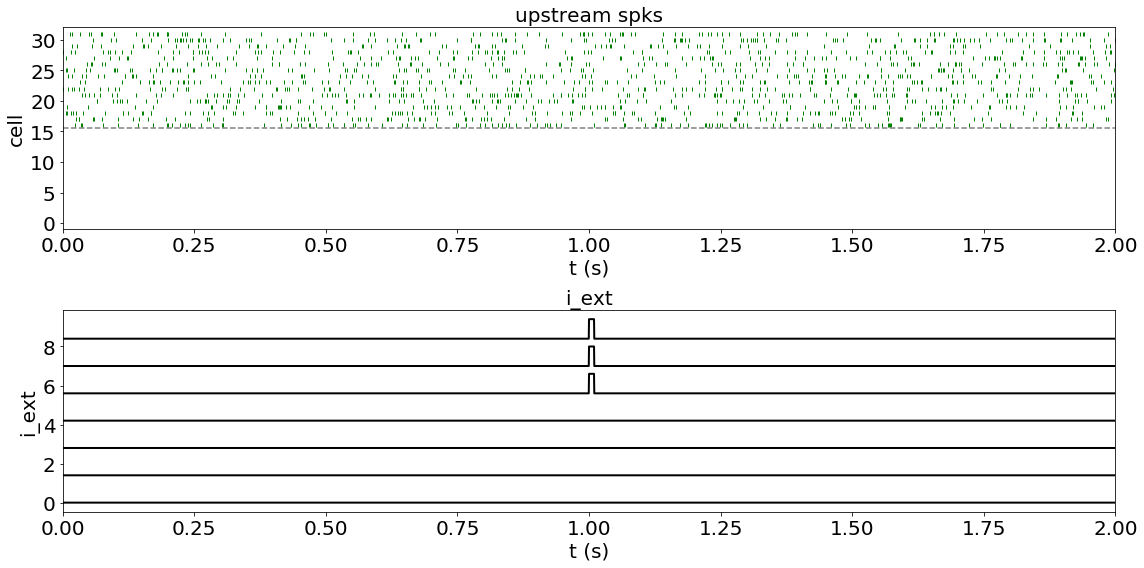

In [7]:
from seq_replay.smln import fix_schedule

schedule_orig = copy(schedule)
t_orig = t.copy()

schedule = fix_schedule(schedule)
t = np.arange(0, schedule['SMLN_DUR'], s_params['DT'])

# build stim
spks_up, i_ext = build_stim(t, trj, ntwk, p, s_params, schedule)

fig, axs = plt.subplots(2, 1, figsize=(16, 8), tight_layout=True)

# plot spks up rasters
## PLs
spk_t_idxs_pl, spk_cells_pl = spks_up[:, pl_idxs].nonzero()
spk_ts_pl = spk_t_idxs_pl * s_params['DT']
axs[0].scatter(spk_ts_pl, spk_cells_pl, c='b', marker='|', s=10, lw=0.5)

## STs
spk_t_idxs_st, spk_cells_st = spks_up[:, st_idxs].nonzero()
spk_ts_st = spk_t_idxs_st * s_params['DT']
axs[0].scatter(spk_ts_st, spk_cells_st + len(pl_idxs), c='g', marker='|', s=10, lw=1)

axs[0].axhline(len(pl_idxs) - .5, color='gray', ls='--')
axs[0].set_xlim(t.min(), t.max())
axs[0].set_ylim(-1, len(pl_idxs) + len(st_idxs))

axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('cell')
axs[0].set_title('upstream spks')

# plot i_ext for triggered and non-triggered PCs
i_ext_pc = i_ext[:, list(pc_ntrg_idxs) + list(pc_trg_idxs)]

offset = 0

for pc in range(i_ext_pc.shape[1]):
    axs[1].plot(t, i_ext_pc[:, pc] + offset, c='k', lw=2)
    offset += 1.4*p['A_TR']

axs[1].set_xlim(t.min(), t.max())
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('i_ext')
axs[1].set_title('i_ext')

for ax in axs:
    set_font_size(ax, 20)

## Compute spk train metrics

In [8]:
from aux import Generic
from seq_replay.smln import dist_to_trj

s_params['metrics']['MIN_SCALE_TRJ'] = 1.25
s_params['metrics']['WDW'] = 0.1
s_params['metrics']['MIN_FRAC_SPK_TRJ'] = 0.75
s_params['metrics']['MAX_AVG_SPK_CT_TRJ'] = 3
s_params['metrics']['TRJ_NON_TRJ_SPK_RATIO'] = 1.5

start = schedule['TRG_START_T']
end = start + s_params['metrics']['WDW']
t_mask = (start <= t) & (t < end)

# (x, y) pts of PCs to plot spks for
xys = [
    (-.75, .75), (0, .75), (0, 0), (0, -.75), (.75, -.75),  # trj
    (-.75, 0), (-.75, -.75), (.75, .75), (.75, 0),  # non-trj
]

# get array of constant ws_plastic
ws_plastic_init = ntwk.ws_up_init['E'][ntwk.plasticity['masks']['E']]
ws_plastic = {'E': np.tile(ws_plastic_init, (len(t), 1))}

### No replay

METRICS_0
{'avg_spk_ct_trj': 1.2465753424657535,
 'frac_spk_non_trj': 0.37662337662337664,
 'frac_spk_trj': 0.38020833333333331,
 'success': False}



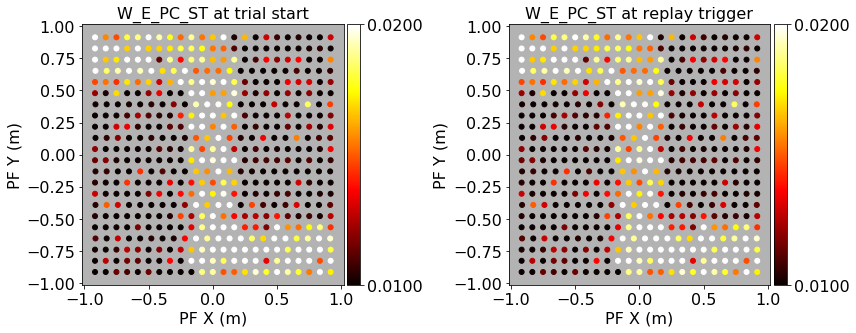

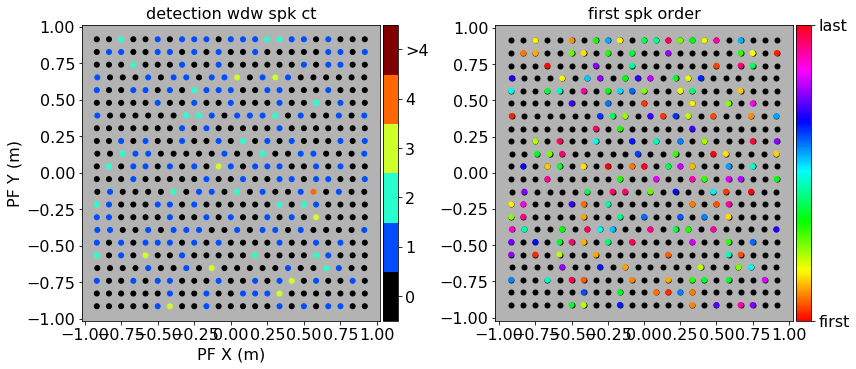

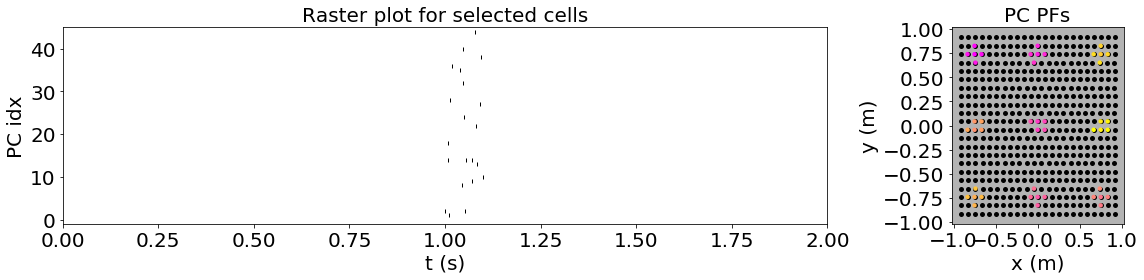

In [9]:
spks_0 = np.zeros((len(t), ntwk.n), bool)
# make apx 2/5 of cells spk
spks_0[np.outer(t_mask, pc_mask)] = np.random.rand(t_mask.sum()*pc_mask.sum()) < 0.002

rslt_0 = Generic(
    ntwk=ntwk,
    p=p,
    s_params=s_params,
    trj_veil=trj_veil,
    schedule=schedule,
    ts=t,
    spks=spks_0,
    ws_plastic=ws_plastic)

# compute metrics
metrics_0, success_0 = get_metrics(rslt_0, s_params)

print('METRICS_0')
pprint(metrics_0)
print('')

# plot heatmaps
heat_maps(rslt_0);

# plot raster
raster(rslt_0, xys, nearest=5, epoch='replay');

### Saturated firing

METRICS_1
{'avg_spk_ct_trj': 10.322916666666666,
 'frac_spk_non_trj': 1.0,
 'frac_spk_trj': 1.0,
 'success': False}



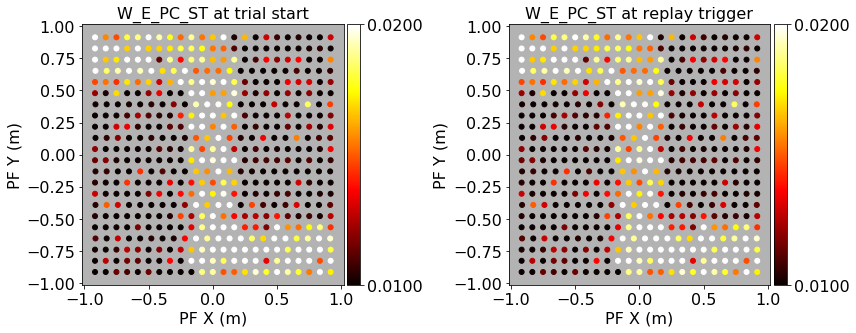

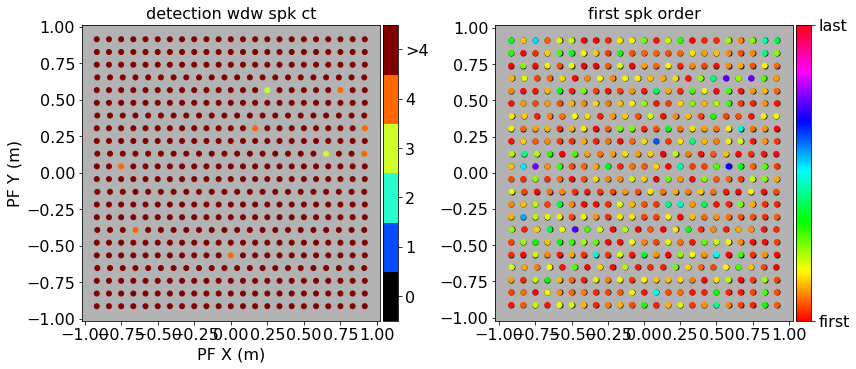

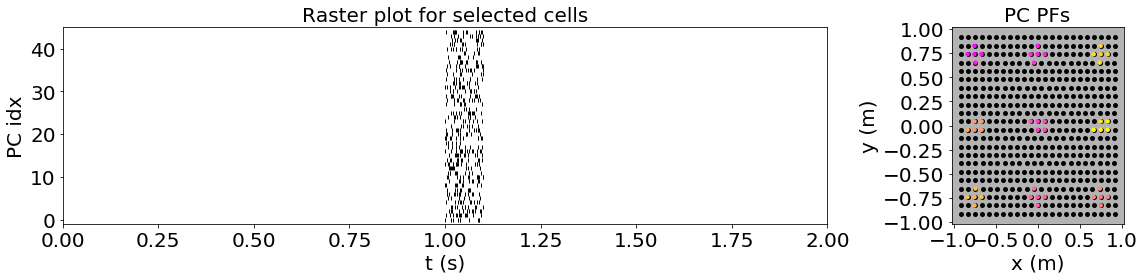

In [10]:
# mock rslt w/ saturated firing
spks_1 = np.zeros((len(t), ntwk.n), bool)
# make each cells spk apx 10 times
spks_1[np.outer(t_mask, pc_mask)] = np.random.rand(t_mask.sum()*pc_mask.sum()) < 0.05

rslt_1 = Generic(
    ntwk=ntwk,
    p=p,
    s_params=s_params,
    trj_veil=trj_veil,
    schedule=schedule,
    ts=t,
    spks=spks_1,
    ws_plastic=ws_plastic)

# compute metrics
metrics_1, success_1 = get_metrics(rslt_1, s_params)

print('METRICS_1')
pprint(metrics_1)
print('')

# plot heatmaps
heat_maps(rslt_1)

# plot raster
raster(rslt_1, xys, nearest=5, epoch='replay');

### Successful replay

METRICS_2
{'avg_spk_ct_trj': 1.0942408376963351,
 'frac_spk_non_trj': 0.081168831168831168,
 'frac_spk_trj': 0.99479166666666663,
 'success': True}



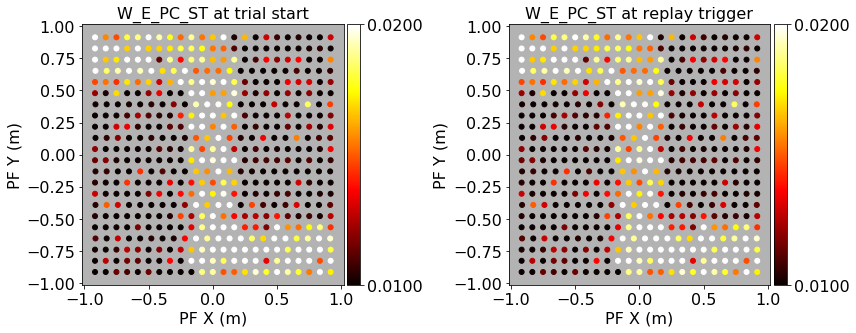

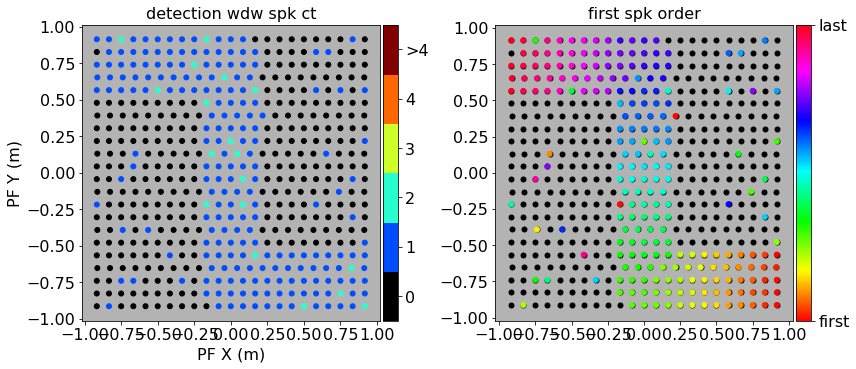

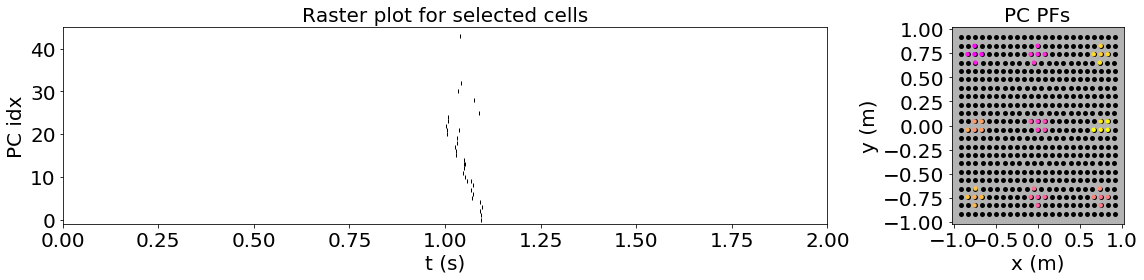

In [11]:
# mock rslt w/ successful replay
spks_2 = np.zeros((len(t), ntwk.n), bool)
## add a few bkgd spks
spks_2[np.outer(t_mask, pc_mask)] = np.random.rand(t_mask.sum()*pc_mask.sum()) < 0.0005

## get idxs of trj PCs, reverse ordered by location along trj
### get trj where speed > 0
x_trj = trj['x'][trj['sp'] > 0]
y_trj = trj['y'][trj['sp'] > 0]
order = dist_to_trj(ntwk.pfxs, ntwk.pfys, x_trj, y_trj)[1]

### set INHs' and non-trj PCs' orders to -1
trj_mask = trj_veil >= (s_params['metrics']['MIN_SCALE_TRJ'] - 1)
ntrj_mask = ~trj_mask

order[ntrj_mask | inh_mask] = -1

## get list of cell idxs for within-trj PCs, ordered by position along trj
pc_idxs_trj = np.argsort(order)[::-1][:(trj_mask & pc_mask).sum()]

## get corresponding spk times
t_spks_pc_trj = np.linspace(start, end, len(pc_idxs_trj))

## add spks
for pc_idx_trj, t_spk_pc_trj in zip(pc_idxs_trj, t_spks_pc_trj):
    spks_2[int(t_spk_pc_trj/s_params['DT']), pc_idx_trj] = True

rslt_2 = Generic(
    ntwk=ntwk,
    p=p,
    s_params=s_params,
    trj_veil=trj_veil,
    schedule=schedule,
    ts=t,
    spks=spks_2,
    ws_plastic=ws_plastic)

# compute metrics
metrics_2, success_2 = get_metrics(rslt_2, s_params)

print('METRICS_2')
pprint(metrics_2)
print('')

# plot heatmaps
heat_maps(rslt_2)

# plot raster
raster(rslt_2, xys, nearest=5, epoch='replay');